Performance: 0.975
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.99 0.01]


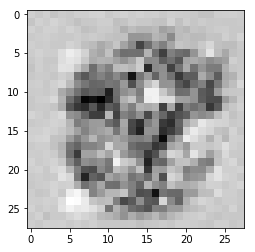

In [3]:
import numpy
# scipy.special needed for sigmoid function expit()
import scipy.special
# library for plotting arrays
import matplotlib.pyplot
# ensure the plots are not printed in separate window
%matplotlib inline

# defines neural network class
class neuralNetwork:
    
    # initialise neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set numer of nodes in each input, hidden, and output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # link weight matrices, w_ih and w_ho
        # weights inside the arrays are w_i_j, where link is from node i to node j in next layer
        # w11 w21
        # w12 w22 etc
        
        self.wih = (numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes)))
        self.who = (numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes)))
        
        # learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        
        pass

    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2) .T
        targets = numpy.array(targets_list, ndmin=2) .T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # error is (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        
        pass
    
    #query the neural network
    def query(self, inputs_list):
        
        #convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2) .T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs

    # backquery the neural network
    # using the same termnimology to each item, 
    # target is values at the right of network
    # hidden_output is signal to the right of middle ones
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

# number of input, hidden, and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# learning rate is 0.1
learning_rate = 0.1

# create instance of neural network object
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

# load the mnist training CSV into a list
training_data_file = open("mnist_dataset/mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

# train the neural network

# epochs = number of times training set is used for training
epochs = 5

for e in range(epochs):
    # go through all records in training set
    for record in training_data_list:
        # split record by commas
        all_values = record.split(',')
        # scale and shift inputs
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create target output values (all 0.01 except target which is 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        # all_values[0] is target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        pass
    pass

# load mnist test CSV into a list
test_data_file = open("mnist_dataset/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

# test the neural network

# scorecard for how well network performs, initially empty
scorecard = []

# go through all records in test set
for record in test_data_list:
    # split by commas
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
#     print(correct_label, "correct label")
    # scale and shift inputs
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # query the network
    outputs = n.query(inputs)
    # index of highest value corresponds to label
    label = numpy.argmax(outputs)
#     print(label, "network's answer")
    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else :
        # network's answer doesn't match correct ansewr, add 0 to scorecard
        scorecard.append(0)
        pass
    pass

# calculate performance score as fraction of correct answers
scorecard_array = numpy.asarray(scorecard)
print("Performance:", scorecard_array.sum() / scorecard_array.size)

# run the network backwards, given a label, see what image it produces

# label to test
label = 8
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')